In [49]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
from collections import Counter
%matplotlib inline

**load imagenet**

run the following cell to put all raw feature together in one gaint file.

In [3]:
N = 50000 # 5000 images
d = 1000 # feature dim
m = 5 # number of models
features = np.zeros((N, m, d)) 
file_list = ['tf_processed.json', 'res152_pred.json', 'lenet_pred.json',  'vgg_pred.json', 'caffe_pred.json']
raw_data = []
for f in file_list:
    raw_data.append(json.load(open(f,'r')))
print 'load all json files'
keys = raw_data[0].keys()
for i in xrange(len(keys)):
    key = keys[i]
    for j in xrange(m):
        features[i, j, :] = raw_data[j][key] 
print 'feature shapes: ', features.shape
pickle.dump(features, open('imagenet-features.p', 'w'))

load all json files
feature shapes:  (50000, 5, 1000)


In [41]:
target = json.load(open('targets.json', 'r'))

In [43]:
ytarget = np.zeros(N)
for i in range(len(keys)):
    ytarget[i] = target[keys[i]]

In [45]:
np.savez(open('imagenet-features.npz','w'), x=features, y=ytarget)

_load the .npz data directly if the cells above has been executed _

T:R:L:V:C=0.920:0.056:0.016:0.008:0.000, 2930 misclassification, 0.058600 error rate.

In [106]:
w_best = np.array([0.92, 0.056, 0.016, 0.008, 0]) 

In [107]:
def ensemble(w, feature, k=5):
    """ deal with single example"""
    assert w.shape[0] == feature.shape[0]
    return np.argsort(np.dot(feature.T, w))[::-1][:k]

def single(feature,k=5):
    """return (m, k) array of the single model predictions"""
    return np.argsort(feature, axis=1)[...,::-1][:, :k]

def robust_prediction(features, target, w, k=5):
    N, m, d = features.shape
    error = np.zeros(N)
    overlap =  np.zeros(N) ### maximum number of overlap for a single target
    for i in xrange(N):
        ensembel_pred = ensemble(w, features[i], k)
        error[i] = int(target[i] not in ensembel_pred)
        single_pred = single(features[i], k)
        single_cnt = dict(Counter(single_pred.flatten().tolist()))
        overlap[i] = max(single_cnt.values())
    return error, overlap

def error_agree(error, overlap, sure= True, k=5):
    """report error rate and portion"""
    if sure:
        error_rate = np.sum(error[overlap>=k],dtype=float)/np.sum(overlap>=k, dtype=float)
        portion = np.sum(overlap>=k, dtype=float)/error.shape[0]
    else:
        error_rate = np.sum(error[overlap<k],dtype=float)/np.sum(overlap<k, dtype=float)
        portion = np.sum(overlap<k, dtype=float)/error.shape[0]
    return error_rate, portion

In [108]:
error, overlap = robust_prediction(features, ytarget, w_best, k=5)

In [109]:
ensemble_error_rate = np.sum(error, dtype=float)/error.shape[0]
ensemble_error_rate

0.058599999999999999

In [110]:
error_five_agree, portion_five_agree = error_agree(error, overlap, k=5)
print error_five_agree, portion_five_agree

0.0327146006685 0.84366


In [111]:
error_four_agree, portion_four_agree = error_agree(error, overlap, k=4)
print error_four_agree, portion_four_agree

0.0468665077971 0.95676


**plot robust prediction**

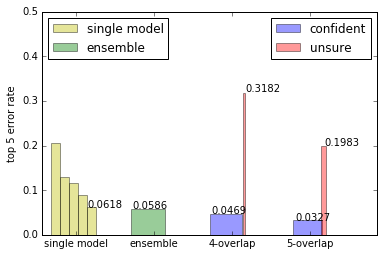

In [139]:
fig, ax = plt.subplots()

four_agree_c = error_agree(error, overlap, sure=True, k=4) ## the second is the proportion
four_agree_u = error_agree(error, overlap, sure=False, k=4)

five_agree_c = error_agree(error, overlap, sure=True, k=5) ## the second is the proportion
five_agree_u = error_agree(error, overlap, sure=False, k=5)

ensemble_ac = np.sum(error, dtype=float)/error.shape[0]

bar_width = 0.3
opacity = 0.4

thin_bar = 0.08
original_acc = [0.0618,  0.0902,  0.1152, 0.1305, 0.2061]
original_acc.reverse() ### put the best model in the end

for i in range(len(original_acc)):
    if i == 0:
        rects0 = plt.bar(thin_bar*(i+1), original_acc[i], thin_bar, alpha=opacity, color='y', label='single model')
    else:
        plt.bar(thin_bar*(i+1), original_acc[i], thin_bar, alpha=opacity, color='y')

    
rects1 = plt.bar(0.5+bar_width, ensemble_ac, bar_width, alpha=opacity, color='g', label='ensemble')
rects2 = plt.bar(1.2+bar_width, four_agree_c[0], four_agree_c[1]*bar_width,  alpha=opacity, color='b', label='confident')
rects3 = plt.bar(1.202+bar_width*2, four_agree_u[0], four_agree_u[1]*bar_width,  alpha=opacity, color='r', label='unsure')
plt.bar(1.95+bar_width, five_agree_c[0], five_agree_c[1]*bar_width,  alpha=opacity, color='b')
plt.bar(2.2+bar_width, five_agree_u[0], five_agree_u[1]*bar_width,  alpha=opacity, color='r')


plt.ylabel('top 5 error rate')
ax.set_ylim([0.0,0.5])

first_legend = plt.legend(handles=[rects0,rects1], loc=2)
axx = plt.gca().add_artist(first_legend)
second_legend = plt.legend(handles=[rects2,rects3], loc=1)


ind = np.array([0.3,1,1.7,2.4])
plt.xticks(ind, ('single model', 'ensemble', '4-overlap', '5-overlap'))

cnt = 0
for p in ax.patches:
    if cnt >=4:
        ax.annotate(str(np.round(float(p.get_height()),4)), (p.get_x() * 1.01, p.get_height() * 1.01))
    cnt += 1
plt.savefig('imagenet_ensemble_confidence_plot.pdf')